# Libraries

In [ ]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount ("/content/gdrive")

Mounted at /content/gdrive


# Loading images

### Unifrom function

In [ ]:
def read_images(data):
  lst_images = []
  for i in range(len(data)):
    img = cv2.imread(data[i])
    img = cv2.resize(img, (150, 150))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lst_images.append(img)
  return lst_images

### Reading images

In [ ]:

from glob import glob
import cv2

data_normal = glob("/content/gdrive/MyDrive/SHAI_CNN_Project/DATASET/train/normal*/*")
data_virus  = glob("/content/gdrive/MyDrive/SHAI_CNN_Project/DATASET/train/virus*/*")
data_covid  = glob("/content/gdrive/MyDrive/SHAI_CNN_Project/DATASET/train/covid*/*")

lst_imgs_normal  = read_images(data_normal)
lst_imgs_virus   = read_images(data_virus)
lst_imgs_covid   = read_images(data_covid)

print("Done ...")

Done ...


### Ploting images

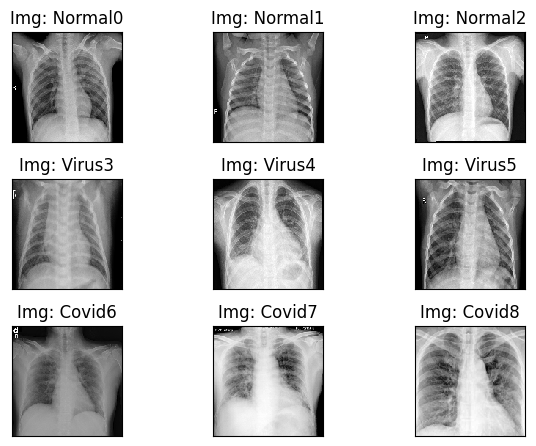

In [ ]:
# Display some images

import matplotlib.pyplot as plt


fig = plt.figure()
j = 0
for i in range(9):
  plt.subplot(3,3, i+1)
  plt.tight_layout()
  if i < 3 and len(lst_imgs_normal) > 0:
    plt.imshow(lst_imgs_normal[i], cmap="gray", interpolation="none")
    plt.title("Img: Normal"+str(j))
  elif (i >= 3 and i < 6) and len(lst_imgs_virus) > 0:
    plt.imshow(lst_imgs_virus[i], cmap="gray", interpolation="none")
    plt.title("Img: Virus"+str(j))
  elif len(lst_imgs_covid) > 0:
    plt.imshow(lst_imgs_covid[i], cmap="gray", interpolation="none")
    plt.title("Img: Covid"+str(j))
  j = j + 1
  plt.xticks([])
  plt.yticks([])

# Preparing data for training

### Gathering images and labels in lists

In [ ]:
# Labels
labels_normal = ["normal"] * len(lst_imgs_normal)
labels_virus  = ["virus"] * len(lst_imgs_virus)
labels_covid  = ["covid"] * len(lst_imgs_covid)

labels = labels_normal + labels_virus+ labels_covid
images = lst_imgs_normal + lst_imgs_virus + lst_imgs_covid

print("Done ...")

Done ...


### Labels distribution

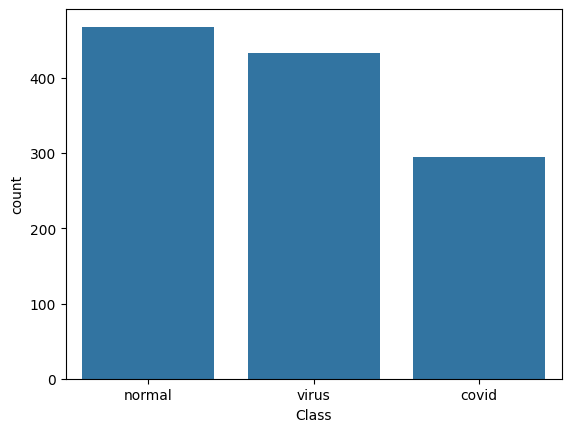

In [ ]:
import seaborn as sns
import pandas as pd

Class_df = pd.DataFrame({"Class" : labels})
#df= pd.DataFrame(labels, columns =["Class"])
sns.countplot(x="Class", data=Class_df)
plt.show()

### One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder (sparse=False)
encoder.fit(np.array(labels).reshape (-1,1))

one_hot_encoded = encoder.transform (np.array(labels).reshape(-1,1))

print(one_hot_encoded)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
one_hot_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
Labels_df = pd.DataFrame(one_hot_encoded, columns= encoder.categories_[0])

### Train & Test Split

In [ ]:
#Y = np.asarray(labels)
X = np.asarray(images)

my_data = X.astype("float32")
my_data = my_data / 255.0

#*******************************************************************************
# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(my_data, Labels_df,
                                test_size= 0.20, stratify= Labels_df, random_state=100)

print("X_train : ",X_train.shape,"  X_test : ",X_test.shape)


X_train :  (956, 150, 150)   X_test :  (240, 150, 150)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print("X_train : ",X_train.shape,"  X_test : ",X_test.shape)

X_train :  (956, 150, 150, 1)   X_test :  (240, 150, 150, 1)


# Training

### The model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=7, strides=1,
                padding="same", activation="relu", name="Conv1", input_shape= (150,150,1)))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                              padding="same", activation="relu", name="Conv2"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                              padding="same", activation="relu", name="Conv3"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool3"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten(name="Flatten1"))
model.add(keras.layers.Dense(32, activation="relu",    name="Dense1"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16,  activation="relu",    name="Dense2"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8,  activation="relu",    name="Dense3"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3,   activation="softmax", name="Output"))

# The model’s summary() method displays all the model’s layers
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 150, 150, 32)      1600      
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        51264     
                                                                 
 Pool2 (MaxPooling2D)        (None, 37, 37, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 37, 37, 128)       73856     
                                                                 
 Pool3 (MaxPooling2D)        (None, 18, 18, 128)       0         
                                                                 
 batch_normalization_5 (Bat  (None, 18, 18, 128)      

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=["accuracy"])

# Training the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/60
30/30 [==============================] - 3s 44ms/step - loss: 0.0137 - accuracy: 0.9948 - val_loss: 0.8007 - val_accuracy: 0.9375
Epoch 2/60
30/30 [==============================] - 1s 34ms/step - loss: 0.0376 - accuracy: 0.9927 - val_loss: 0.9255 - val_accuracy: 0.9250
Epoch 3/60
30/30 [==============================] - 1s 34ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.8223 - val_accuracy: 0.9208
Epoch 4/60
30/30 [==============================] - 1s 30ms/step - loss: 0.0220 - accuracy: 0.9948 - val_loss: 1.3664 - val_accuracy: 0.9250
Epoch 5/60
30/30 [==============================] - 1s 28ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 3.1353 - val_accuracy: 0.9000
Epoch 6/60
30/30 [==============================] - 1s 29ms/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 0.9291 - val_accuracy: 0.9250
Epoch 7/60
30/30 [==============================] - 1s 31ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.8383 - val_accuracy: 0.9250
Epoch 8/60
30

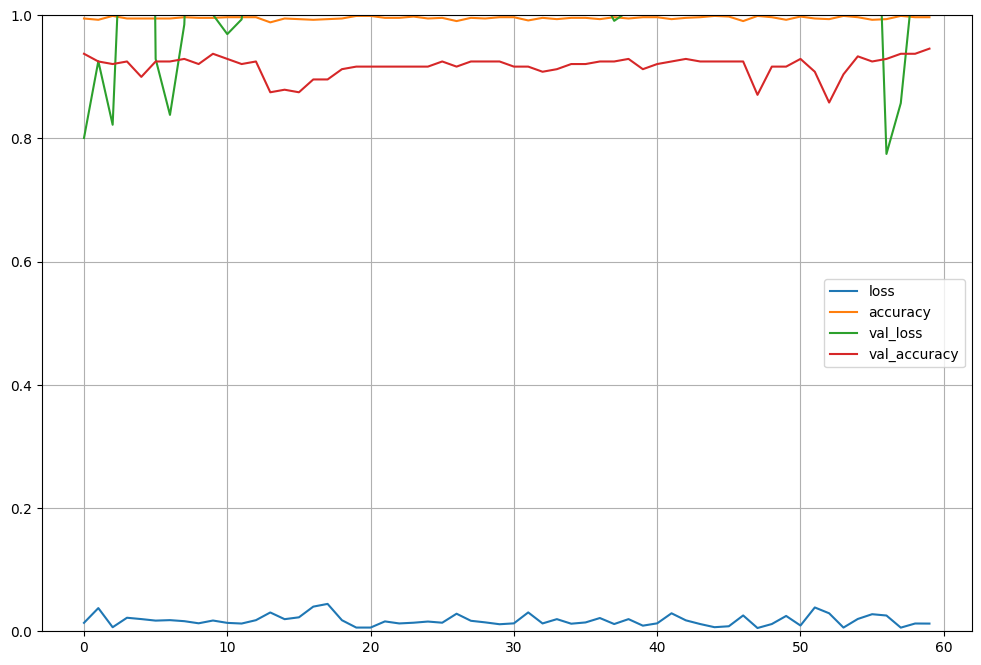

8/8 [==============================] - 0s 12ms/step - loss: 1.8597 - accuracy: 0.9458
Loss     :  1.859742283821106
accuracy :  0.9458333253860474


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

# Predicting Test images for kaggle competition

In [ ]:
data_test = glob("/content/gdrive/MyDrive/SHAI_CNN_Project/DATASET/test/*")

lst_imgs_test  = read_images(data_test)

print("Done ...")

Done ...


In [ ]:
T = np.asarray(lst_imgs_test)
T_data = T.astype("float32")
T_data = T_data / 255.0

In [ ]:
T_data = T_data.reshape(T_data.shape[0],T_data.shape[1], T_data.shape[2], 1)

In [ ]:
T_pred = model.predict(T_data)

17/17 [==============================] - 0s 10ms/step


In [ ]:
T_pred_bin = [[1 if val >= threshold else 0 for val in values] for values in T_pred ]

In [ ]:
class_mapping = {(1,0,0): "covid",(0,1,0): "normal",(0,0,1): "virus" }

T_pred_class = [class_mapping[tuple(one_hot)] for one_hot in T_pred_bin]

In [ ]:
data_dir = '/content/gdrive/MyDrive/SHAI_CNN_Project/DATASET/test'

df_results = pd.DataFrame({'Image': os.listdir(data_dir), "Label": T_pred_class})

In [ ]:
File_path = "/content/gdrive/MyDrive/SHAI_CNN_Project/sample_submission4.csv"

df_results.to_csv(File_path, index=False)